# Desafio FieldPRO

## Entendendo o problema

O objetivo deste desafio é construir um modelo de calibração de um sensor de
chuva baseado em impactos mecânicos.

O sistema de medição de chuva funciona por meio de uma placa eletrônica com
um piezoelétrico, um acumulador de carga e um sensor de temperatura. Os
dados são transmitidos de hora em hora.

O impacto das gotas de chuva gera vibrações no piezoelétrico, que induzem uma
corrente elétrica. A corrente elétrica não é medida diretamente, mas é acumulada
ao longo do tempo e gera uma queda na carga do acumulador.

A carga do acumulador é medida de hora em hora e transmitida com o
nome de piezo_charge. A temperatura da placa é transmitida sob o nome
piezo_temperature e pode ser importante na calibração.

Um evento de reset na placa pode afetar o comportamento do acumulador de
carga, e o número total de resets da placa desde que foi ligada pela primeira vez
é transmitido com o nome num_of_resets.

As medidas realizadas pelo sensor estão no arquivo Sensor_FieldPRO.csv, para
comparação, foram utilizadas medidas de uma estação metereológica próxima,
que estão no arquivo Estacao_Convencional.csv.

Outras medidas que podem ser úteis na modelagem são: a temperatura do ar externo air_temperature_100, umidade relativa do ar externo air_humidity_100 e a pressão atmosférica atm_pressure_main.

As medidas do sensor incluem a carga medida no acumulador, a temperatura da
placa, o número de resets da placa e as condições atmosféricas do ambiente.


Bônus: Realizar o deploy do modelo em uma plataforma de cloud.

## Bibliotecas utilizadas

In [618]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.model_selection import StratifiedShuffleSplit


## Importação dos dados e análise exploratória

In [484]:
# Importação do arquivo CSV e criação dos dataframes:

## Dataframe contendo dados da estação convencional
df_conv = pd.read_csv('C:\\Users\\migue\\Desktop\\arquivos desafio\\Estacao_Convencional.csv', sep = ',')

## Dataframe contendo dados do Sensor FieldPRO
df_fpro = pd.read_csv('C:\\Users\\migue\\Desktop\\arquivos desafio\\Sensor_FieldPRO.csv', sep = ',')

### Visualizando arquivo

### Estação convencional

In [485]:
# Visualização do arquivo
df_conv.head()

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0
2,2020-09-01,02:00:00,0.0
3,2020-09-01,03:00:00,0.0
4,2020-09-01,04:00:00,0.0


In [486]:
df_c = df_conv.copy()

In [487]:
#Transformando a coluna de data e a coluna de hora em uma coluna no formato date time
df_c['datetime'] = df_c['data']+" "+df_c['Hora (Brasília)']
df_c['datetime'] = pd.to_datetime(df_c['datetime'])
df_c.drop(['data','Hora (Brasília)'], axis =1, inplace= True)

In [488]:
df_c

,chuva,datetime
0,0.0,2020-09-01 00:00:00
1,0.0,2020-09-01 01:00:00
2,0.0,2020-09-01 02:00:00
3,0.0,2020-09-01 03:00:00
4,0.0,2020-09-01 04:00:00
...,...,...
2251,0.0,2020-12-03 19:00:00
2252,0.0,2020-12-03 20:00:00
2253,0.0,2020-12-03 21:00:00
2254,0.0,2020-12-03 22:00:00


In [489]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   chuva     2256 non-null   float64       
 1   datetime  2256 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.4 KB


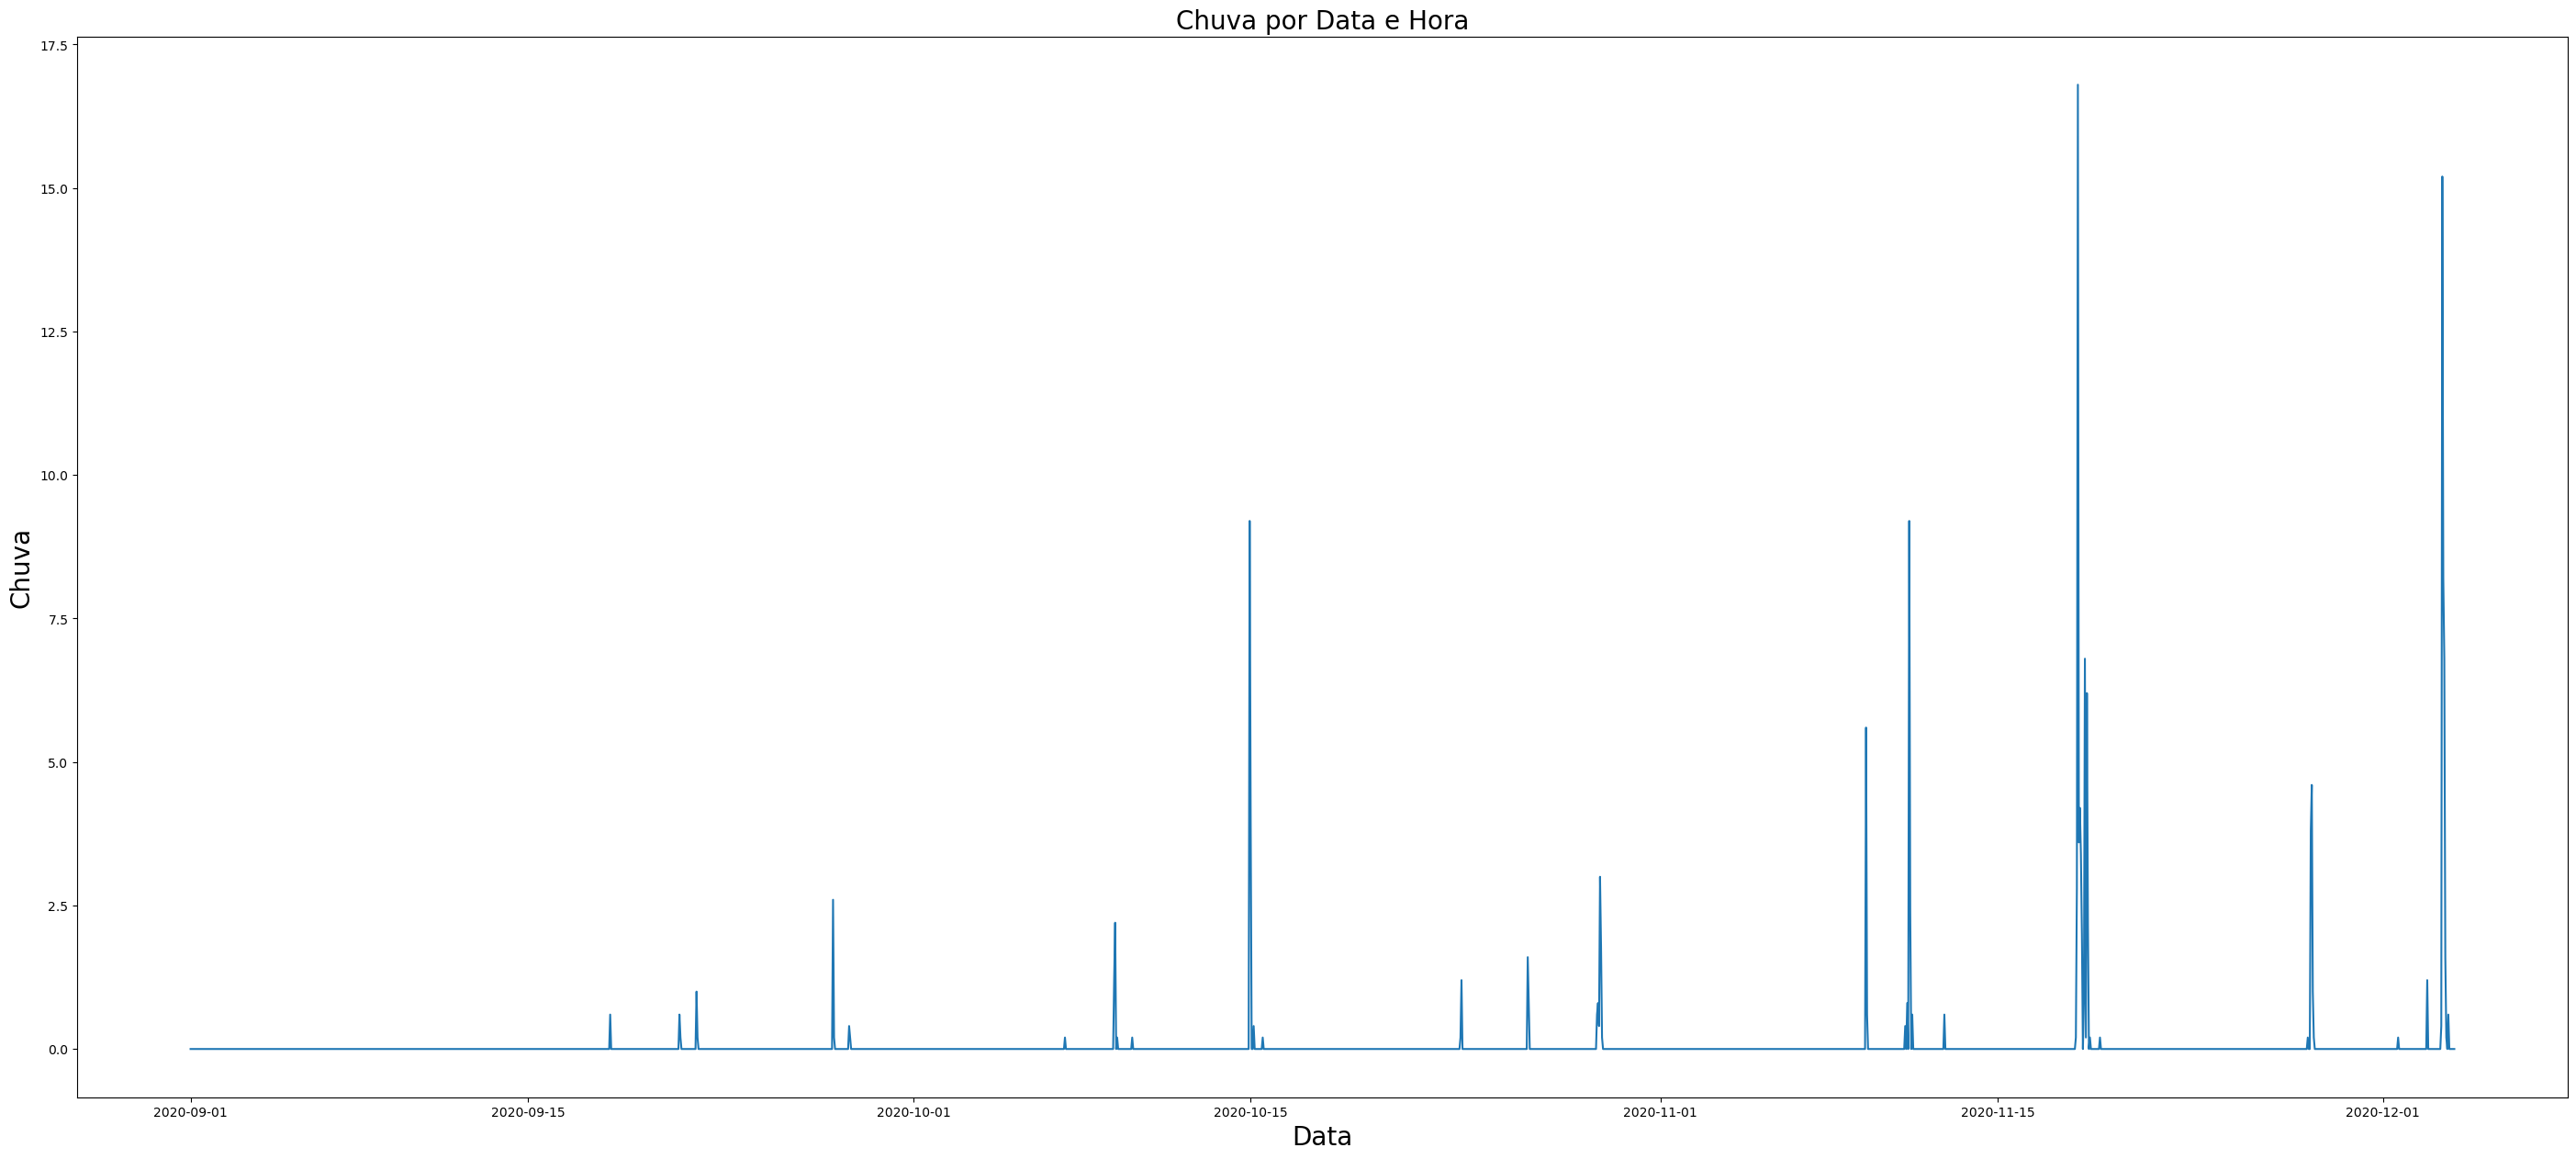

In [490]:
#Plotando a linha do tempo
plt.figure(figsize=(35,15))
# Create a line chart
plt.plot(df_c['datetime'], df_c['chuva'])

# Add a title
plt.title('Chuva por Data e Hora', fontsize = 20)

# Add labels to the x-axis and y-axis
plt.xlabel('Data', fontsize = 20)
plt.ylabel('Chuva', fontsize = 20)

# Show the plot
plt.show()

[[<AxesSubplot:title={'center':'chuva'}>]]


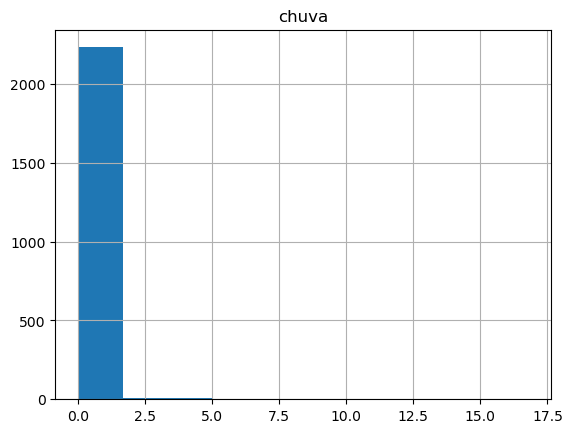

In [491]:
#checando o histograma dos dados

print(df_conv.hist())

In [492]:
df_conv['chuva'].value_counts()

0.0     2192
0.2       18
0.6        7
0.4        5
0.8        4
1.2        3
1.0        2
2.2        2
9.2        2
6.8        2
1.6        2
6.2        1
2.0        1
4.6        1
3.8        1
4.2        1
15.2       1
3.4        1
5.6        1
3.6        1
16.8       1
2.8        1
2.4        1
1.8        1
3.0        1
4.0        1
2.6        1
8.2        1
Name: chuva, dtype: int64

In [493]:
#podemos verificar que não tem linhas com missing values

### Sensor FieldPro

In [494]:
# Visualização do arquivo
df_fpro.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31


In [495]:
df_f = df_fpro.copy()

In [496]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datetime – utc       1711 non-null   object 
 1   air_humidity_100     1705 non-null   float64
 2   air_temperature_100  1705 non-null   float64
 3   atm_pressure_main    1711 non-null   int64  
 4   num_of_resets        1711 non-null   int64  
 5   piezo_charge         1711 non-null   int64  
 6   piezo_temperature    1711 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 93.7+ KB


In [497]:
#podemos ver que duas colunas possuem poucos valores missings

In [498]:
df_f[(df_f['air_humidity_100'].isna())]

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
6,2020-10-01T05:00:00Z,NaN,NaN,9411,0,44537,30
12,2020-10-01T12:00:00Z,NaN,NaN,9438,0,43874,30
16,2020-10-01T16:00:00Z,NaN,NaN,9460,0,43259,30
20,2020-10-01T21:00:00Z,NaN,NaN,9379,0,41914,37
30,2020-10-02T08:00:00Z,NaN,NaN,9398,0,41083,19


In [499]:
#como são poucos, para o melhor treinamento do modelo, vou remover as 30 horas iniciais que contém valores missings

df_f = df_f.iloc[31:,:]
df_f.reset_index(inplace = True, drop = True)

In [500]:
#removendo o 'z' da coluna datetime
df_f['Datetime – utc'] = pd.to_datetime(df_f['Datetime – utc'])
df_f['Datetime – utc'] = df_f['Datetime – utc'].dt.strftime('%Y-%m-%d %H:%M:%S')


In [501]:
df_f

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-10-02 09:00:00,69.0,19.862,9407,0,41023,19
1,2020-10-02 10:00:00,62.0,22.356,9414,0,40964,18
2,2020-10-02 11:00:00,39.0,30.108,9422,0,40891,24
3,2020-10-02 12:00:00,28.0,34.518,9425,0,40789,32
4,2020-10-02 14:00:00,23.0,37.684,9422,0,40533,40
...,...,...,...,...,...,...,...
1675,2020-12-11 09:00:00,82.0,19.480,9422,3,20669,17
1676,2020-12-11 10:00:00,69.0,24.000,9429,3,20606,19
1677,2020-12-11 11:00:00,63.0,25.440,9436,3,20529,25
1678,2020-12-11 12:00:00,60.0,27.160,9439,3,20442,28


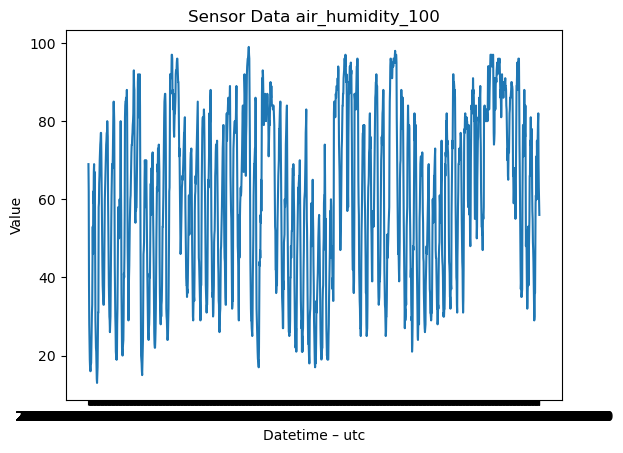

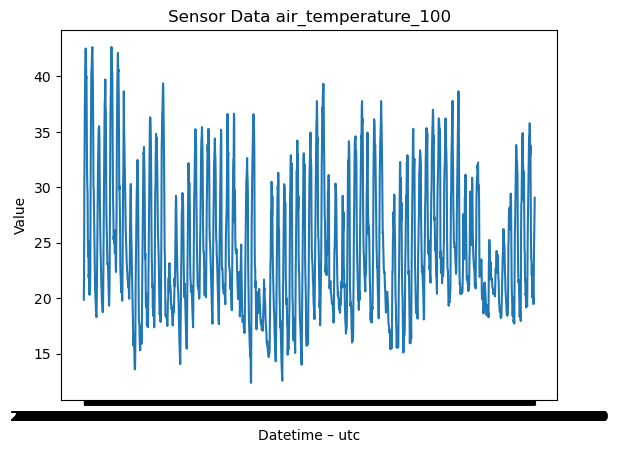

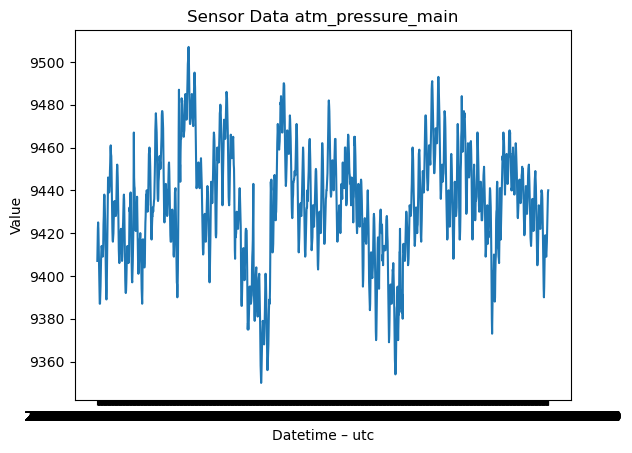

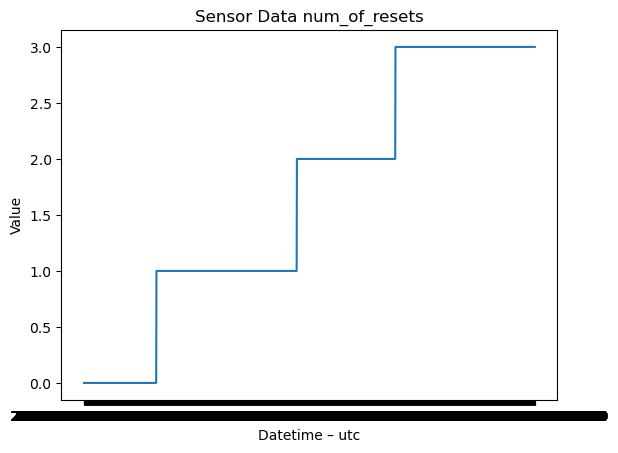

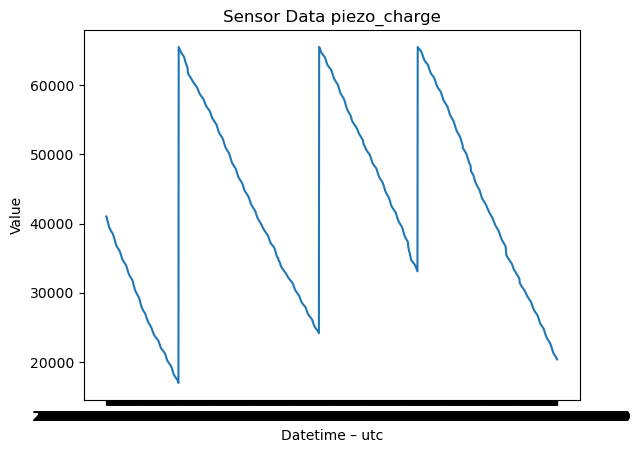

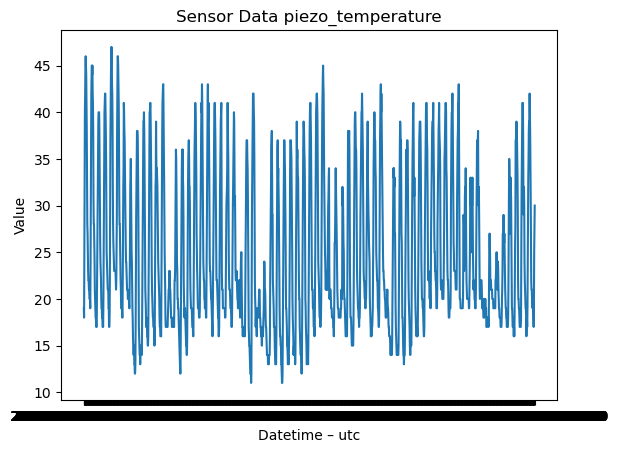

In [502]:
#criando os gráficos das features
for i in df_f.iloc[:,1:].columns:
    plt.title("Sensor Data "+i)
    plt.plot(df_f['Datetime – utc'], df_f[i])
    plt.xlabel("Datetime – utc")
    plt.ylabel("Value")
    plt.show()

### Unindo os dataframes

In [505]:
df_c.set_index(df_c.datetime, drop=True, append=False, inplace=True, verify_integrity=True)
df_c = df_c.chuva
df_c.head()

datetime
2020-09-01 00:00:00    0.0
2020-09-01 01:00:00    0.0
2020-09-01 02:00:00    0.0
2020-09-01 03:00:00    0.0
2020-09-01 04:00:00    0.0
Name: chuva, dtype: float64

In [506]:
df_f.columns = ['datetime', 'air_humidity_100', 'air_temperature_100', 'atm_pressure_main',
       'num_of_resets', 'piezo_charge', 'piezo_temperature']
df_f['datetime'] = pd.to_datetime(df_f['datetime'])
df_f.set_index(df_f['datetime'], drop=True, append=False, inplace=True, verify_integrity=True)
df_f = df_f.iloc[:,1:]
df_f.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
datetime,,,,,,
2020-10-02 09:00:00,69.0,19.862,9407,0,41023,19
2020-10-02 10:00:00,62.0,22.356,9414,0,40964,18
2020-10-02 11:00:00,39.0,30.108,9422,0,40891,24
2020-10-02 12:00:00,28.0,34.518,9425,0,40789,32
2020-10-02 14:00:00,23.0,37.684,9422,0,40533,40


In [604]:
df = df_f.merge(df_c, how='left', on='datetime')

In [605]:
df.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
datetime,,,,,,,
2020-10-02 09:00:00,69.0,19.862,9407,0,41023,19,0.0
2020-10-02 10:00:00,62.0,22.356,9414,0,40964,18,0.0
2020-10-02 11:00:00,39.0,30.108,9422,0,40891,24,0.0
2020-10-02 12:00:00,28.0,34.518,9425,0,40789,32,0.0
2020-10-02 14:00:00,23.0,37.684,9422,0,40533,40,0.0


In [606]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1680 entries, 2020-10-02 09:00:00 to 2020-12-11 13:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   air_humidity_100     1680 non-null   float64
 1   air_temperature_100  1680 non-null   float64
 2   atm_pressure_main    1680 non-null   int64  
 3   num_of_resets        1680 non-null   int64  
 4   piezo_charge         1680 non-null   int64  
 5   piezo_temperature    1680 non-null   int64  
 6   chuva                1498 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 105.0 KB


In [607]:
#Checando onde a chuva está missing

df[(df.chuva.isna())]

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
datetime,,,,,,,
2020-12-04 00:00:00,97.0,18.98,9428,3,34889,19,NaN
2020-12-04 01:00:00,97.0,18.62,9441,3,34833,17,NaN
2020-12-04 02:00:00,97.0,18.46,9441,3,34778,17,NaN
2020-12-04 03:00:00,96.0,18.82,9428,3,34723,17,NaN
2020-12-04 04:00:00,94.0,19.36,9417,3,34665,18,NaN
...,...,...,...,...,...,...,...
2020-12-11 09:00:00,82.0,19.48,9422,3,20669,17,NaN
2020-12-11 10:00:00,69.0,24.00,9429,3,20606,19,NaN
2020-12-11 11:00:00,63.0,25.44,9436,3,20529,25,NaN


In [608]:
#removendo as linhas com valores faltantes para a melhor calibração do modelo

df = df[~(df.chuva.isna())]

df

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
datetime,,,,,,,
2020-10-02 09:00:00,69.0,19.862,9407,0,41023,19,0.0
2020-10-02 10:00:00,62.0,22.356,9414,0,40964,18,0.0
2020-10-02 11:00:00,39.0,30.108,9422,0,40891,24,0.0
2020-10-02 12:00:00,28.0,34.518,9425,0,40789,32,0.0
2020-10-02 14:00:00,23.0,37.684,9422,0,40533,40,0.0
...,...,...,...,...,...,...,...
2020-12-03 19:00:00,86.0,20.880,9412,3,35217,20,0.0
2020-12-03 20:00:00,90.0,20.980,9409,3,35132,19,0.0
2020-12-03 21:00:00,93.0,20.620,9408,3,35068,20,0.0


### Inserindo uma coluna de ruído gaussiano

Isso ajudará na etapa de feature selection

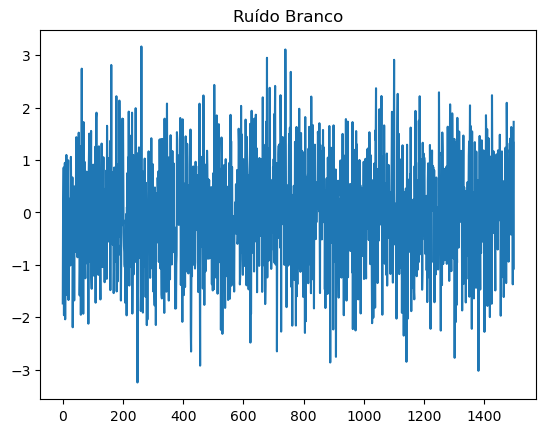

In [609]:
# Create a Gaussian white noise array
rb = np.random.normal(0, 1, len(df))
    
plt.title("Ruído Branco")
plt.plot(rb)
plt.show()

In [610]:
# Inserindo o ruido no df, ele servirá de base para seleção das features

df['ruido'] = rb

### Verificando a correlação entre as colunas e a chuva e selecionando features

In [611]:
#o objetivo aqui é verificar se existe alguma coluna que possui menos correlação do que um ruido branco,
#o que significa nenhuma correlação
df.corr().chuva.sort_values(ascending = True)

atm_pressure_main     -0.067087
air_temperature_100   -0.058662
piezo_temperature     -0.054312
piezo_charge          -0.018984
ruido                 -0.005032
num_of_resets          0.062534
air_humidity_100       0.110559
chuva                  1.000000
Name: chuva, dtype: float64

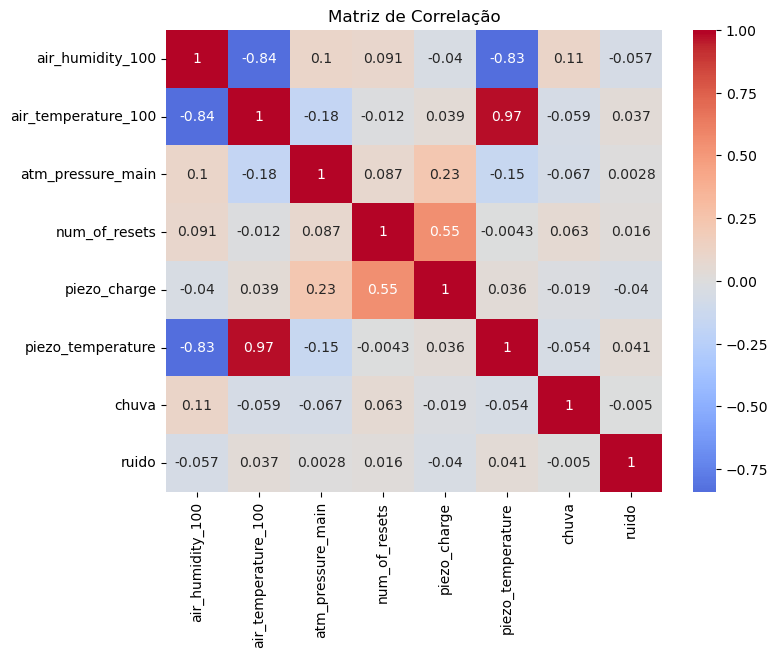

In [612]:
# Calcular a matriz de correlação
correlation_matrix = df.corr()

# Plotar a matriz de correlação usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlação")
plt.show()

In [613]:
#Verificamos que o ruído possui correlação extremamente fraca, como esperado
#Não há nenhuma feature com força de correlação menor, porém, podemos verificar que os valores 
# de correlação são fracos para todas as features.

df.drop('ruido',axis =1, inplace = True)

In [614]:
df

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
datetime,,,,,,,
2020-10-02 09:00:00,69.0,19.862,9407,0,41023,19,0.0
2020-10-02 10:00:00,62.0,22.356,9414,0,40964,18,0.0
2020-10-02 11:00:00,39.0,30.108,9422,0,40891,24,0.0
2020-10-02 12:00:00,28.0,34.518,9425,0,40789,32,0.0
2020-10-02 14:00:00,23.0,37.684,9422,0,40533,40,0.0
...,...,...,...,...,...,...,...
2020-12-03 19:00:00,86.0,20.880,9412,3,35217,20,0.0
2020-12-03 20:00:00,90.0,20.980,9409,3,35132,19,0.0
2020-12-03 21:00:00,93.0,20.620,9408,3,35068,20,0.0


In [615]:
df.chuva = np.where((df.chuva > 0.0), 1, 0)

<AxesSubplot:>

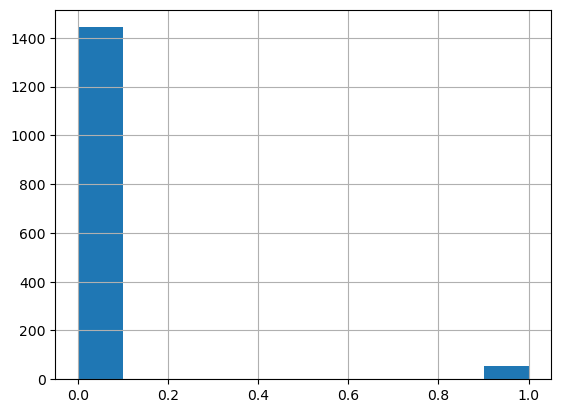

In [617]:
df.chuva.hist()

## Criação do modelo

Preciso ser sincero, não entendo muito de modelos de calibração, pelo que pude entender enquanto pesquisava se trata de criar um modelo de regressão linear usando como label o resultado da chuva, isso eu tentei e não deu certo, o que estou fazendo é tentar criar um modelo que previna a se está chovendo ou não de acordo com um modelo de classificação. Seguirei esse caminho.

### Pré-processamento

No pré-processamento estou fazendo algumas coisas, a primeira é criar x e y. Depois eu separo os dados entre treino e teste usando a metodologia StratifiedShuffleSplit, que embaralha e separa os dados entre treino e teste mantendo a proporção de classes entre os splits.

Depois eu normalizo usando o Standard Scaler e ploto a curva dos dados normalizados.

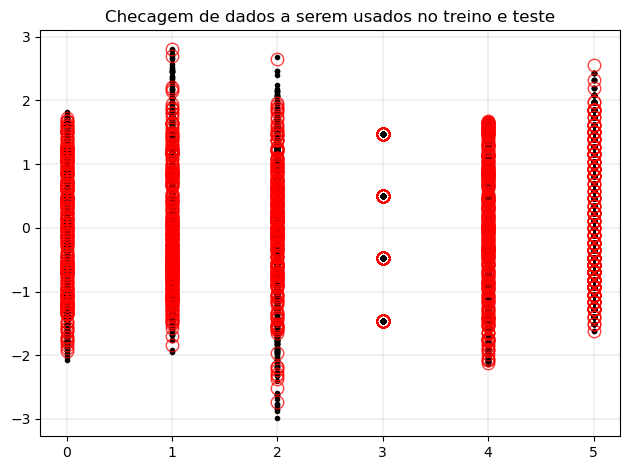

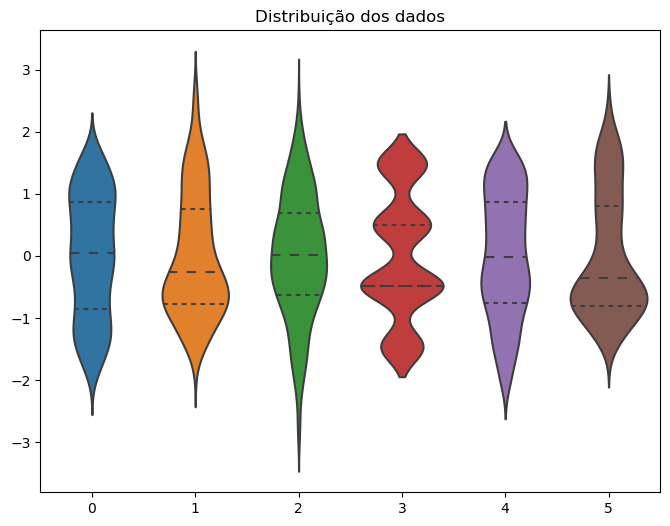

In [635]:
X=df.iloc[:,:-1]
y=df['chuva']


# Criar uma instância do StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Dividir os dados em conjuntos de treinamento e teste
for train_index, test_index in sss.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# Crie um objeto StandardScaler
scaler = StandardScaler()

# Ajuste o objeto Scaler aos dados
scaler.fit(x_train)

# Transforme os dados
norm_x_treino = scaler.transform(x_train)
norm_x_teste = scaler.transform(x_test)

arr_y_treino = np.ravel(np.array(y_train))
arr_y_teste = np.ravel(np.array(y_test))

plt.plot(norm_x_treino.T,'ok',fillstyle='full',markersize=3,alpha=1)
plt.plot(norm_x_teste.T,'or',fillstyle='none',markersize=9,alpha=0.75,markeredgewidth=1)
plt.grid(':', linewidth=0.25)
plt.title("Checagem de dados a serem usados no treino e teste")
plt.tight_layout()
plt.show()

# Create a violin plot using seaborn
plt.figure(figsize=(8, 6))
sns.violinplot(data=norm_x_treino, inner="quart")
plt.title("Distribuição dos dados")
plt.show()

### Criação do modelo 1 - (Esse eu fiz antes de alterar a atividade para classificação, é um regressor, foi um teste)

In [530]:
# Train the model
model = lgb.LGBMRegressor()
model.fit(norm_x_treino, arr_y_treino)


LGBMRegressor()

In [531]:

# Evaluate the model
y_pred = model.predict(norm_x_teste)
print('Mean squared error:', np.mean((arr_y_teste - y_pred)**2))



Mean squared error: 0.3386785265183565


In [532]:
def r2_score(y_true, y_pred):
    # Calculate the sum of squared residuals
    ss_residuals = ((y_true - y_pred) ** 2).sum()

    # Calculate the total sum of squares (y_true - mean(y_true)) ** 2
    ss_total = ((y_true - y_true.mean()) ** 2).sum()

    # Calculate R²
    r2 = 1 - (ss_residuals / ss_total)
    return r2


In [533]:
r2_score(arr_y_teste, y_pred)

-0.17252191810837036

### Geralmente os resultados do lgbm são muito mais eficazes, vou rodar um paramGrid e verificar se há outras opções de hiperparâmetros que melhoram os resultados

In [534]:
# hiperparâmetros a serem testados
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, -1],  
    'min_child_samples': [5, 10, 20],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.5],
}

In [535]:
# LightGBM
regressor = lgb.LGBMRegressor()

In [536]:
# cria o grid de parâmetros
grid_search = GridSearchCV(regressor, param_grid, cv=3)

In [537]:
# Execute a busca em grade
grid_search.fit(norm_x_treino, arr_y_treino)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, -1],
                         'min_child_samples': [5, 10, 20],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]})

In [538]:
# Melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(grid_search.best_params_)

Melhores hiperparâmetros:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 5, 'n_estimators': 100, 'subsample': 0.8}


In [539]:
# Melhor pontuação R² encontrada
print("Melhor pontuação R²:")
print(grid_search.best_score_)

Melhor pontuação R²:
0.08015310646275109


### Fiz essa parte diversas vezes e nao cheguei em nenhum resultado, decidi testar um modelo automl para checar o que poderia fazer

In [540]:
from flaml import AutoML



In [623]:
automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'accuracy',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'classification',  # task type
    "log_file_name": 'houses_experiment.log',  # flaml log file
    "seed": 7654321,  # random seed
}
automl.fit(X_train=norm_x_treino, y_train=arr_y_treino, **settings)

[flaml.automl.logger: 08-02 11:28:54] {1693} INFO - task = classification
[flaml.automl.logger: 08-02 11:28:54] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 08-02 11:28:54] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 08-02 11:28:54] {1801} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 08-02 11:28:54] {1911} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 08-02 11:28:54] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-02 11:28:54] {2347} INFO - Estimated sufficient time budget=241s. Estimated necessary time budget=0s.
[flaml.automl.logger: 08-02 11:28:54] {2394} INFO -  at 0.0s,	estimator lgbm's best error=0.0367,	best estimator lgbm's best error=0.0367
[flaml.automl.logger: 08-02 11:28:54] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-02 11:28:54] {2394} INFO -  at 0.1s,	estimator lgbm's best error=0.0367,	best estimator lgbm's best error=0.0367
[flaml.auto

In [624]:
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 86, 'num_leaves': 11, 'min_child_samples': 44, 'learning_rate': 0.844209868764753, 'log_max_bin': 8, 'colsample_bytree': 0.9583291528325945, 'reg_alpha': 0.028467617664515193, 'reg_lambda': 0.12540576876352233}
Best r2 on validation data: 0.9708
Training duration of best run: 0.02204 s
LGBMClassifier(colsample_bytree=0.9583291528325945,
               learning_rate=0.844209868764753, max_bin=255,
               min_child_samples=44, n_estimators=86, num_leaves=11,
               reg_alpha=0.028467617664515193, reg_lambda=0.12540576876352233,
               verbose=-1)


<BarContainer object of 6 artists>

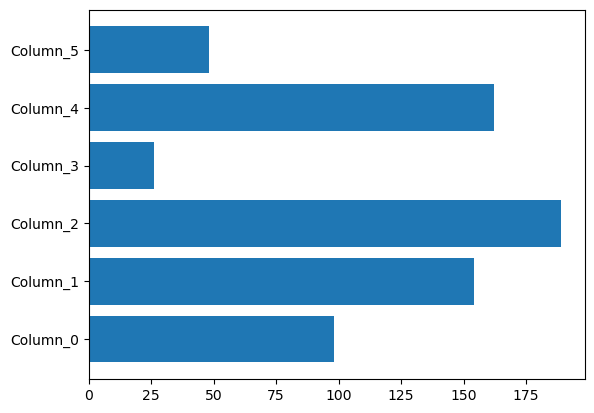

In [625]:
import matplotlib.pyplot as plt
plt.barh(automl.feature_names_in_, automl.feature_importances_)

In [630]:
y_pred = automl.predict(norm_x_teste)


In [632]:
from flaml.automl.ml import sklearn_metric_loss_score

print('acc', '=', sklearn_metric_loss_score('accuracy', y_pred, arr_y_teste))


acc = 0.030000000000000027


### Como pode ver não tive um resultado satisfatório. Tive muita dificuldade de entender um caminho para a realização do desafio. Desconheço metodologias de calibração e até pensei em criar uma rede deep learning usando camadas LSTMs mas também não consegui ver como isso poderia resolver o problema. No fundo acho que acabei não compreendendo o objetivo do desafio claramente levando em conta o que estava escrito no texto de introdução do desafio.